# STAGE 3

## Reading In

In [1]:
pip install aceso

Note: you may need to restart the kernel to use updated packages.


In [2]:
from access import Access, weights, Datasets
import geopandas as gpd #for handling geodataframes
import pandas as pd   # for data manipulation
from shapely.geometry import Point
from shapely.geometry import Polygon
import itertools
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, RobustScaler, QuantileTransformer, StandardScaler
from shapely import wkt
import aceso
from IPython.display import display
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

<jemalloc>: MADV_DONTNEED does not work (memset will be used instead)
<jemalloc>: (This is the expected behaviour if you are running under QEMU)


In [3]:
stn_org = pd.read_csv('STG2/pop_in_1000_gdf.csv')
stn_org.drop(['geometry','Unnamed: 0', 'name'], axis = 1, inplace = True)
stn_org['geometry'] = stn_org['stn_centroid'].apply(wkt.loads)
stn_org = gpd.GeoDataFrame(stn_org, geometry='geometry')
stn_org.crs = 'EPSG:27700'

dest_org = pd.read_csv('STG2/transformed_df_geo.csv')
dest_org.drop(['Unnamed: 0', 'name', 'stn_a_canopy_score',
       'largest_adjacent_green', 'park_overlap_count', 'min_entry_dist',
       'park_canopy_score', 'w_area_within_park', 'CF', 'LT', 'ST',
       'ST_scaled', 'LT_scaled', 'CF_scaled', 'green_score',
       'activity_score', 'final_score','stn_area'], axis = 1, inplace = True)
dest_org['geometry'] = dest_org['geometry'].apply(wkt.loads)
# Convert DataFrame to GeoDataFrame
dest_org = gpd.GeoDataFrame(dest_org, geometry='geometry')
dest_org.crs = 'EPSG:27700'

## Gaussian 2 Step Floating Catchment Area : Estimate catchment accessibility for each provider

### Loading In
Find the general distance decay interval depending on the size of park


Using the top 30 stations with access to top green space, find the list of stations that fall within their catchment area and their distnace to the dest station.

Define Catchment area intervals/weights.


The average length of a tube journey is 9km [https://tfl.gov.uk/corporate/transparency/freedom-of-information/foi-request-detail?referenceId=FOI-3120-2223]



This works, because the cost travel matrix is based on the tube track distance, not euclidean.

|Distance|Decay|
|---|---|
|1000 | 0.39|
|2 |0.36 |
|3 |0.33|
|4 | 0.29| 
|5 | 0.25|
|6 | 0.19|
|7 | 0.13|
|8 | 0.06|
|9 | 0.01|


|Distance|Decay|
|---|---|
|1000 | 0.37|
|2 |0.31 |
|3 |0.22|
|4 | 0.11| 
|5 | 0.01|

In [4]:
top100 = pd.read_csv("STG2/top_100_final_score.csv")
top50 = pd.read_csv("STG2/top_50_final_score.csv")
#----------------------------------------------------------
dist = pd.read_csv('formatted_list.csv')
dist.drop('Unnamed: 0', axis = 1, inplace = True)
dist.rename(columns = {'source': 'Source', 'target': 'Target', 'length':'journey_distance'}, inplace = True)
temp26 = pd.read_csv('temp26_result.csv')
temp28 = pd.read_csv('temp28_result.csv')
temprank = pd.read_csv('temp_rank_result.csv')
#----------------------------------------------------------
# lines = gpd.read_file('STG2/network/tfl_lines.json')
lines = gpd.read_file('tfl_line_CLEANED.json')
lines = lines.to_crs('epsg:27700')

## Distance Decay

Create distance decays for all 4 travel cost matrixes dist, temp26, temp28, temprank, and in both top50 and top100

In [10]:
def distance_decay(dkj, d0):
    if dkj <= d0:
        decay_factor = np.exp(-0.5 * (dkj / d0)**2) - np.exp(-0.5)
    else:
        decay_factor = 0
    return decay_factor

In this function, we use the provided equation to calculate the decay factor based on the distance dkj and the threshold d0. If the distance dkj is less than or equal to d0, we use the first part of the equation. If dkj is greater than d0, the decay factor will be set to zero.

In [11]:
dkj = 4900 #actual distance
d0 = 5000 #threshold
decay_factor = distance_decay(dkj, d0)
print("Decay factor:", decay_factor)

Decay factor: 0.012128987789989054


In [12]:
# Distance decay table
decay_table = pd.DataFrame({
    'Distance': [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000],
    'Decay': [0.39, 0.36, 0.33, 0.29, 0.25, 0.19, 0.13, 0.06, 0.01]
})

# decay_table = pd.DataFrame({
#     'Distance': [1000, 2000, 3000, 4000, 5000],
#     'Decay': [0.37, 0.31, 0.22, 0.11, 0.01]
# })

def distance_decay(distance):
    # Find the index of the closest distance in the decay table and get the corresponding decay
    closest_distance_idx = (decay_table['Distance'] - distance).abs().idxmin()
    decay = decay_table.loc[closest_distance_idx, 'Decay']
    return decay

In [13]:
# List of DataFrames
data_frames = [dist, temp26, temprank]
data_frame_names = ['dist','temp26', 'temprank']
top_values = [top100, top50]

# Loop through each DataFrame and its corresponding name
for df, df_name in zip(data_frames, data_frame_names):
    for top_df, top_value in zip(top_values, ['top100', 'top50']):
        buffer_names = []
        final_scores = []
        stations = []
        distances = []
        decay_values = []

        for _, row in top_df.iterrows():
            buffer_name = row['buffer_name']
            final_score = row['final_score_transformed']

            stations_df = df[
                (df['Source'] == buffer_name) & (df['journey_distance'] <= 9000)
            ].sort_values(by='journey_distance')

            for _, station_row in stations_df.iterrows():
                station = station_row['Target']
                distance = station_row['journey_distance']
                decay = distance_decay(distance)

                buffer_names.append(buffer_name)
                final_scores.append(final_score)
                stations.append(station)
                distances.append(distance)
                decay_values.append(decay)

        # Create the final DataFrame
        output_df = pd.DataFrame({
            'buffer_name': buffer_names,
            'final_score_transformed': final_scores,
            'stations': stations,
            'distance': distances,
            'decay': decay_values
        })

        # Save the DataFrame with appropriate naming
        output_name = f"catchment_decay_{df_name}_{top_value}"
        globals()[output_name] = output_df
        
        print(f"Processed DataFrame '{df_name}' with '{top_value}' and saved as '{output_name}'")

Processed DataFrame 'dist' with 'top100' and saved as 'catchment_decay_dist_top100'
Processed DataFrame 'dist' with 'top50' and saved as 'catchment_decay_dist_top50'
Processed DataFrame 'temp26' with 'top100' and saved as 'catchment_decay_temp26_top100'
Processed DataFrame 'temp26' with 'top50' and saved as 'catchment_decay_temp26_top50'
Processed DataFrame 'temprank' with 'top100' and saved as 'catchment_decay_temprank_top100'
Processed DataFrame 'temprank' with 'top50' and saved as 'catchment_decay_temprank_top50'


In [14]:
print(f" catchment_decay_dist_top100 {len(catchment_decay_dist_top100)}")
print(f" catchment_decay_temp26_top100 {len(catchment_decay_temp26_top100)}")
print(f" catchment_decay_temprank_top100 {len(catchment_decay_temprank_top100)}")
# print(f" catchment_decay_temprank_top50 {len(catchment_decay_temprank_top50)}")
print('----')

print(f" number of unique stations in catchment_decay_dist_top100  {len(catchment_decay_dist_top100['stations'].unique())}")
print(f" number of unique stations in catchment_decay_temp26_top100 {len(catchment_decay_temp26_top100['stations'].unique())}")
# print(f" number of unique stations in catchment_decay_temp28_top100 {len(catchment_decay_temp28_top100['stations'].unique())}")
print(f" number of unique stations in catchment_decay_temprank_top100 {len(catchment_decay_temprank_top100['stations'].unique())}")

print('----')
print(f" number of unique stations in catchment_decay_dist_top50  {len(catchment_decay_dist_top50['stations'].unique())}")
print(f" number of unique stations in catchment_decay_temp26_top50  {len(catchment_decay_temp26_top50['stations'].unique())}")
# print(f" number of unique stations in catchment_decay_temp28_top50  {len(catchment_decay_temp28_top50['stations'].unique())}")
print(f" number of unique stations in catchment_decay_temprank_top50  {len(catchment_decay_temprank_top50['stations'].unique())}")

print('----')
print(f" number of unique stations in stn_org  {len(stn_org['buffer_name'].unique())}")

 catchment_decay_dist_top100 8328
 catchment_decay_temp26_top100 7185
 catchment_decay_temprank_top100 3603
----
 number of unique stations in catchment_decay_dist_top100  337
 number of unique stations in catchment_decay_temp26_top100 335
 number of unique stations in catchment_decay_temprank_top100 331
----
 number of unique stations in catchment_decay_dist_top50  295
 number of unique stations in catchment_decay_temp26_top50  293
 number of unique stations in catchment_decay_temprank_top50  276
----
 number of unique stations in stn_org  378


All this shows that the 9km catchment is large enough for every origin station to fall in the catchment of 100 top green stations, 355 stations.

Whereas the 9km catchment of 50top green station captures 319-325 catches of the total of 418.

In [34]:
node_list =['Earls Court', 'Gloucester Road', 'West Kensington', 'Barons Court', 'Hammersmith',
 'Ravenscourt Park', 'Stamford Brook', 'Turnham Green', 'Chiswick Park', 'Acton Town',
 'Ealing Common', 'South Kensington', 'Sloane Square', 'Ealing Broadway', 'Richmond',
 'Kew Gardens', 'Gunnersbury', 'West Brompton', 'Wimbledon Park', 'Southfields',
 'East Putney', 'Putney Bridge', 'Parsons Green', 'Fulham Broadway', 'High Street Kensington',
 'Notting Hill Gate', 'Bayswater', 'Paddington', 'Edgware Road', 'Victoria',
 'St Jamess Park', 'Westminster', 'Embankment', 'Temple', 'Blackfriars', 'Mansion House',
 'Cannon Street', 'Monument', 'Tower Hill', 'Aldgate East', 'Whitechapel',
 'Stepney Green', 'Mile End', 'Bow Road', 'Bromley-by-Bow', 'West Ham', 'Plaistow',
 'Upton Park', 'East Ham', 'Barking', 'Upney', 'Becontree', 'Dagenham Heathway',
 'Dagenham East', 'Elm Park', 'Hornchurch', 'Upminster Bridge', 'Upminster', 'Kensington',
 'Wembley Park', 'Kingsbury', 'Queensbury', 'Canons Park', 'Stanmore', 'Stratford',
 'Canning Town', 'North Greenwich', 'Canary Wharf', 'Canada Water', 'Bermondsey',
 'London Bridge', 'Southwark', 'Waterloo', 'Green Park', 'Bond Street', 'Baker Street',
 'St Johns Wood', 'Swiss Cottage', 'Finchley Road', 'Neasden', 'Dollis Hill',
 'Willesden Green', 'Kilburn', 'West Hampstead', 'Liverpool Street', 'Maryland',
 'Forest Gate', 'Manor Park', 'Ilford', 'Seven Kings', 'Goodmayes', 'Chadwell Heath',
 'Romford', 'Gidea Park', 'Harold Wood', 'Brentwood', 'Shenfield', 'Aldgate',
 'Great Portland Street', 'Euston Square', 'Kings Cross St Pancras', 'Farringdon',
 'Barbican', 'Moorgate', 'Goldhawk Road', 'Shepherds Bush Market', 'Wood Lane',
 'Latimer Road', 'Ladbroke Grove', 'Westbourne Park', 'Royal Oak', 'Harrow & Wealdstone',
 'Kenton', 'South Kenton', 'North Wembley', 'Wembley Central', 'Stonebridge Park',
 'Harlesden', 'Willesden Junction', 'Kensal Green', 'Queens Park', 'Kilburn Park',
 'Maida Vale', 'Warwick Avenue', 'Marylebone', 'Regents Park', 'Oxford Circus',
 'Piccadilly Circus', 'Charing Cross', 'Lambeth North', 'Elephant & Castle', 'Uxbridge',
 'Hillingdon', 'Ickenham', 'Ruislip', 'Ruislip Manor', 'Eastcote', 'Rayners Lane',
 'West Harrow', 'Harrow-on-the-Hill', 'Amersham', 'Chalfont & Latimer', 'Chorleywood',
 'Rickmansworth', 'Moor Park', 'Northwood', 'Northwood Hills', 'Pinner', 'North Harrow',
 'Northwick Park', 'Preston Road', 'Croxley', 'Watford', 'Chesham', 'Cambridge Heath',
 'Bethnal Green', 'London Fields', 'Hackney Downs', 'Rectory Road', 'Stoke Newington',
 'Stamford Hill', 'Seven Sisters', 'Bruce Grove', 'White Hart Lane', 'Silver Street',
 'Edmonton Green', 'Southbury', 'Turkey Street', 'Theobalds Grove', 'Cheshunt',
 'Enfield Town', 'Bush Hill Park', 'Emerson Park', 'Clapton', 'St James Street',
 'Walthamstow Central', 'Wood Street', 'Highams Park', 'Chingford', 'South Acton',
 'Kilburn High Road', 'Acton Central', 'Kensal Rise', 'Brondesbury Park', 'Brondesbury',
 'Finchley Road & Frognal', 'Hampstead Heath', 'Gospel Oak', 'Kentish Town West',
 'Camden Road', 'Caledonian Road & Barnsbury', 'Highbury & Islington', 'Canonbury',
 'Dalston Kingsland', 'Hackney Central', 'Homerton', 'Hackney Wick', 'Shadwell',
 'Wapping', 'Rotherhithe', 'Surrey Quays', 'New Cross Gate', 'Shoreditch High Street',
 'New Cross', 'Sydenham', 'Crystal Palace', 'Queens Road Peckham', 'Peckham Rye',
 'Denmark Hill', 'Clapham High Street', 'Wandsworth Road', 'Clapham Junction',
 'Imperial Wharf', 'South Hampstead', 'Euston', 'Bushey', 'Watford High Street',
 'Carpenders Park', 'Hatch End', 'Headstone Lane', 'Watford Junction', 'Upper Holloway',
 'Crouch Hill', 'Harringay Green Lanes', 'South Tottenham', 'Blackhorse Road',
 'Walthamstow Queens Road', 'Leyton Midland Road', 'Leytonstone High Road',
 'Wanstead Park', 'Woodgrange Park', 'Brockley', 'Honor Oak Park', 'Forest Hill',
 'Penge West', 'Anerley', 'Norwood Junction', 'Dalston Junction', 'Haggerston', 'Hoxton',
 'Shepherds Bush', 'Battersea Park', 'West Acton', 'North Acton', 'West Ruislip',
 'Ruislip Gardens', 'South Ruislip', 'Northolt', 'Greenford', 'Perivale', 'Hanger Lane',
 'East Acton', 'White City', 'Holland Park', 'Queensway', 'Lancaster Gate',
 'Marble Arch', 'Tottenham Court Road', 'Holborn', 'Chancery Lane', 'St Pauls', 'Bank',
 'Leyton', 'Leytonstone', 'Snaresbrook', 'South Woodford', 'Woodford', 'Buckhurst Hill',
 'Loughton', 'Debden', 'Theydon Bois', 'Epping', 'Wanstead', 'Redbridge', 'Gants Hill',
 'Newbury Park', 'Barkingside', 'Fairlop', 'Hainault', 'Grange Hill', 'Chigwell',
 'Roding Valley', 'Brixton', 'Stockwell', 'Vauxhall', 'Pimlico', 'Warren Street',
 'Finsbury Park', 'Tottenham Hale', 'Stratford High Street', 'Abbey Road', 'Star Lane',
 'Royal Victoria', 'Limehouse', 'Westferry', 'West India Quay', 'Heron Quays',
 'South Quay', 'Crossharbour', 'Mudchute', 'Island Gardens', 'Cutty Sark', 'Greenwich',
 'Deptford Bridge', 'Elverson Road', 'Lewisham', 'Tower Gateway', 'Poplar',
 'All Saints', 'Blackwall', 'East India', 'Custom House', 'Prince Regent',
 'Royal Albert', 'Beckton Park', 'Cyprus', 'Gallions Reach', 'Beckton', 'Langdon Park',
 'Devons Road', 'Bow Church', 'Pudding Mill Lane', 'Stratford International',
 'Woolwich Arsenal', 'King George V', 'West Silvertown', 'Pontoon Dock',
 'London City Airport', 'South Ealing', 'Knightsbridge', 'Hyde Park Corner',
 'Leicester Square', 'Covent Garden', 'Russell Square', 'Caledonian Road',
 'Holloway Road', 'Arsenal', 'Manor House', 'Turnpike Lane', 'Wood Green',
 'Bounds Green', 'Arnos Grove', 'Southgate', 'Oakwood', 'Cockfosters',
 'South Harrow', 'Sudbury Hill', 'Sudbury Town', 'Alperton', 'Park Royal',
 'North Ealing', 'Heathrow Terminal 4', 'Hatton Cross', 'Heathrow Terminals 2 & 3',
 'Hounslow West', 'Hounslow Central', 'Hounslow East', 'Osterley', 'Boston Manor',
 'Northfields', 'Heathrow Terminal 5', 'Edgware', 'Burnt Oak', 'Colindale',
 'Hendon Central', 'Brent Cross', 'Golders Green', 'Hampstead', 'Belsize Park',
 'Chalk Farm', 'Camden Town', 'Angel', 'Old Street', 'Borough', 'Kennington', 'Oval',
 'Clapham North', 'Clapham Common', 'Clapham South', 'Balham', 'Tooting Bec',
 'Tooting Broadway', 'Colliers Wood', 'South Wimbledon', 'Morden', 'Finchley Central',
 'Mill Hill East', 'High Barnet', 'Totteridge & Whetstone', 'Woodside Park',
 'West Finchley', 'East Finchley', 'Highgate', 'Archway', 'Tufnell Park',
 'Kentish Town', 'Mornington Crescent', 'Goodge Street', 'Battersea Power Station',
 'Nine Elms']


In [42]:
existing_stations = set(catchment_decay_dist_top100['stations'])
# Find stations in the list that are not in the DataFrame
exclude_dist_list = [station for station in node_list if station not in existing_stations]

existing_stations = set(catchment_decay_temp26_top100['stations'])
# Find stations in the list that are not in the DataFrame
exclude_dist_temp26 = [station for station in node_list if station not in existing_stations]

existing_stations = set(catchment_decay_temprank_top100['stations'])
# Find stations in the list that are not in the DataFrame
exclude_dist_rank = [station for station in node_list if station not in existing_stations]

exclude_dist_df = dest_org[dest_org['buffer_name'].isin(exclude_dist_list)]
exclude_temp26_df = dest_org[dest_org['buffer_name'].isin(exclude_dist_temp26)]
exclude_rank_df = dest_org[dest_org['buffer_name'].isin(exclude_dist_rank)]

In [85]:
m1m2_num_compare = exclude_rank_df.merge(exclude_dist_df, on = 'buffer_name', how = 'left')

In [87]:
a= m1m2_num_compare[m1m2_num_compare['green_score_transformed_y'].isna()]
drop_off =a['buffer_name'].to_list()
drop_off

['Sudbury Hill',
 'Balham',
 'Tooting Bec',
 'Neasden',
 'Dollis Hill',
 'Wembley Park']

In [76]:
m1m2_num_compare[m1m2_num_compare['geometry_y'].isna()]

,geometry_x,buffer_name,green_score_transformed_x,activity_score_transformed_x,final_score_transformed_x,geometry_y,green_score_transformed_y,activity_score_transformed_y,final_score_transformed_y


In [50]:
len(exclude_dist_df)

44

In [47]:
len(exclude_temp26_df)

46

In [46]:
len(exclude_rank_df)

50

/opt/conda/lib/python3.10/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


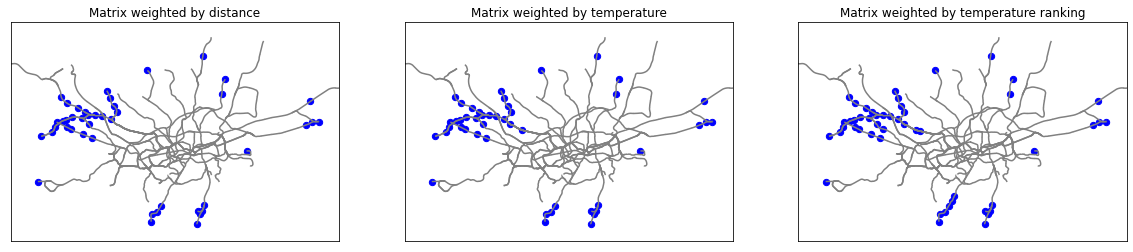

In [88]:
fig, axes = plt.subplots(1, 3,figsize=(20, 15))

axes[0].set_title("Matrix weighted by distance")
axes[0].set_xlim([500000, 560000])
axes[0].set_ylim([165000, 205000])
axes[0].set_xticks([])
axes[0].set_yticks([])


lines.plot(ax=axes[0], color='grey', edgecolor='white')
# Plot excluded stations with blue markers
exclude_dist_df.plot(column="buffer_name", ax=axes[0], marker='o', markersize=40, color='blue', legend=False)

axes[1].set_xlim([500000, 560000])
axes[1].set_ylim([165000, 205000])
lines.plot(ax=axes[1], color='grey', edgecolor='white')
# Plot excluded stations with blue markers
exclude_temp26_df.plot(column="buffer_name", ax=axes[1], marker='o', markersize=40, color='blue', legend=False)
axes[1].set_title("Matrix weighted by temperature")
axes[1].set_xticks([])
axes[1].set_yticks([])


axes[2].set_xlim([500000, 560000])
axes[2].set_ylim([165000, 205000])
lines.plot(ax=axes[2], color='grey', edgecolor='white')
# Plot excluded stations with blue markers
exclude_rank_df.plot(column="buffer_name", ax=axes[2], marker='o', markersize=40, color='blue', legend=False)
axes[2].set_title("Matrix weighted by temperature ranking")
axes[2].set_xticks([])
axes[2].set_yticks([])

plt.savefig("output/exlcuded_3Models.png")

## Equation Input

### Calculate Rj and Ai for distance weighted network

In [16]:
# ADD DESTINATION GEOMETRY & WEIGHTED POP
full_df = catchment_decay_dist_top100.merge(dest_org, on='buffer_name', how='left')
full_df.drop(['green_score_transformed', 'activity_score_transformed', 'final_score_transformed_y'], axis=1, inplace=True)
full_df.rename(columns={'buffer_name': 'dest_green', 'stations': 'origin_catchment', 'geometry': 'dest_geom', 'final_score_transformed_x': 'final_score_transformed'}, inplace=True)
    
# # # ADD ORIGIN GEOMETRY
full_df = full_df.merge(stn_org, left_on='origin_catchment', right_on='buffer_name', how='left')
full_df.drop(['stn_centroid', 'buffer_name'], axis=1, inplace=True)
full_df.rename(columns={'geometry': 'origin_geom'}, inplace=True)

## CALCULATE Rj
full_df['weighted_value'] = full_df['decay'] * full_df['weighted_pop']
grouped_data = full_df.groupby(['dest_green', 'final_score_transformed'])['weighted_value'].sum().reset_index()
grouped_data['Rj'] = grouped_data['final_score_transformed'] / grouped_data['weighted_value'] * 100000
Rj = grouped_data[['dest_green', 'Rj']]
Rj = Rj.sort_values(by='Rj', ascending=False)
Rj = Rj.merge(dest_org, left_on='dest_green', right_on='buffer_name', how='left')
Rj.drop(['green_score_transformed', 'activity_score_transformed', 'final_score_transformed', 'buffer_name'], axis=1, inplace=True)
    
# merge back with original df
full_df_Rj = full_df.merge(Rj, on='dest_green', how='left')
    
## CALCULATE Ai
full_df_Rj['Ai'] = full_df_Rj['decay'] * full_df_Rj['Rj']
Ai = full_df_Rj.groupby(['origin_catchment'])['Ai'].sum().reset_index()
Ai = Ai.sort_values(by='Ai', ascending=False)
Ai = Ai.merge(stn_org, left_on='origin_catchment', right_on='buffer_name', how='left')
Ai.drop(['buffer_name', 'weighted_pop', 'stn_centroid'], axis=1, inplace=True)
    
    # merge back with original df
full_df_Rj.drop(['Ai'], axis=1, inplace=True)
full_df_Rj_Ai = full_df_Rj.merge(Ai, on='origin_catchment', how='left')
full_df_Rj_Ai.drop(['geometry_x', 'geometry_y'], axis=1, inplace=True)

    # Create GeoDataFrames
Ai_gdf = gpd.GeoDataFrame(Ai, geometry='geometry')
Ai_gdf.crs = 'EPSG:27700'

Rj_dest_gdf = gpd.GeoDataFrame(Rj, geometry='geometry')
Rj_dest_gdf.crs = 'EPSG:27700'

Rj_dest_gdf.rename(columns = {'Rj':'Rj_dist'}, inplace = True)

In [56]:
Ai[Ai['origin_catchment'] == 'Tottenham Court Road']

,origin_catchment,Ai,geometry
7,Tottenham Court Road,1.050687,POINT (529783.232 181329.162)


### Calculate Ai for temperature weighted network with distance based Rj

In [17]:

# ADD DESTINATION GEOMETRY

rank_df = catchment_decay_temprank_top100.merge(dest_org, on='buffer_name', how='left')
rank_df.drop(['green_score_transformed', 'activity_score_transformed', 'final_score_transformed_y'], axis=1, inplace=True)
rank_df.rename(columns={'buffer_name': 'dest_green', 'stations': 'origin_catchment', 'geometry': 'dest_geom', 'final_score_transformed_x': 'final_score_transformed'}, inplace=True)
    
# # # ADD ORIGIN GEOMETRY
rank_df = rank_df.merge(stn_org, left_on='origin_catchment', right_on='buffer_name', how='left')
rank_df.drop(['stn_centroid', 'buffer_name'], axis=1, inplace=True)
rank_df.rename(columns={'geometry': 'origin_geom'}, inplace=True)

# # ===============ORIGINAL ==================
# rank_df = rank_df.merge(stn_org, left_on = 'dest_green', right_on='buffer_name', how='left')
# rank_df.drop('stn_centroid', axis=1, inplace=True)
    
#     # ADD DESTINATION GEOMETRY
# rank_df = rank_df.merge(dest_org, left_on='origin_catchment', right_on='buffer_name', how='left')
# rank_df.drop(['green_score_transformed', 'activity_score_transformed', 'final_score_transformed_y'], axis=1, inplace=True)
# rank_df.rename(columns={'geometry': 'origin_geom', 'final_score_transformed_x': 'final_score_transformed'}, inplace=True)
# # ===============ORIGINAL ==================


## CALCULATE Rj
rank_df['weighted_value'] = rank_df['decay'] * rank_df['weighted_pop']
grouped_data_rank = rank_df.groupby(['dest_green', 'final_score_transformed'])['weighted_value'].sum().reset_index()
grouped_data_rank['Rj_rank'] = grouped_data_rank['final_score_transformed'] / grouped_data_rank['weighted_value'] * 100000
Rj = grouped_data_rank[['dest_green', 'Rj_rank']]
Rj = Rj.sort_values(by='Rj_rank', ascending=False)
Rj = Rj.merge(dest_org, left_on='dest_green', right_on='buffer_name', how='left')
Rj.drop(['green_score_transformed', 'activity_score_transformed', 'final_score_transformed', 'buffer_name'], axis=1, inplace=True)


# THIS RJ BELOW NEEDS TO BE THE RJ FROM THE ORIGINAL DISTANT BASED RJ.
rank_df_Rj = rank_df.merge(Rj_dest_gdf, on = 'dest_green', how = 'left')
rank_df_Rj.drop('geometry', inplace= True, axis = 1)

# merge back with original df
rank_df_Rj = rank_df_Rj.merge(Rj, on='dest_green', how='left')

    ## CALCULATE Ai
rank_df_Rj['Ai'] = rank_df_Rj['decay'] * rank_df_Rj['Rj_rank'] #Rj_dist
Ai_rank = rank_df_Rj.groupby(['origin_catchment'])['Ai'].sum().reset_index()
Ai_rank = Ai_rank.sort_values(by='Ai', ascending=False)
Ai_rank = Ai_rank.merge(stn_org, left_on='origin_catchment', right_on='buffer_name', how='left')
Ai_rank.drop(['buffer_name', 'weighted_pop', 'stn_centroid'], axis=1, inplace=True)
    
    # merge back with original df
rank_df_Rj.drop(['Ai'], axis=1, inplace=True)
rank_df_Rj_Ai = rank_df_Rj.merge(Ai_rank, on='origin_catchment', how='left')
    
    # Create GeoDataFrames
Ai_rank_gdf = gpd.GeoDataFrame(Ai_rank, geometry='geometry')
Ai_rank_gdf.crs = 'EPSG:27700'
    

In [18]:
# catchment_decay_temp26_top100

# ADD DESTINATION GEOMETRY

temp26_df = catchment_decay_temp26_top100.merge(dest_org, on='buffer_name', how='left')
temp26_df.drop(['green_score_transformed', 'activity_score_transformed', 'final_score_transformed_y'], axis=1, inplace=True)
temp26_df.rename(columns={'buffer_name': 'dest_green', 'stations': 'origin_catchment', 'geometry': 'dest_geom', 'final_score_transformed_x': 'final_score_transformed'}, inplace=True)
    
# # # ADD ORIGIN GEOMETRY
temp26_df = temp26_df.merge(stn_org, left_on='origin_catchment', right_on='buffer_name', how='left')
temp26_df.drop(['stn_centroid', 'buffer_name'], axis=1, inplace=True)
temp26_df.rename(columns={'geometry': 'origin_geom'}, inplace=True)

# # ===============ORIGINAL ==================
# # full_df = df.merge(stn_org, on='buffer_name', how='left')
# # full_df.drop('stn_centroid', axis=1, inplace=True)
# # full_df.rename(columns={'buffer_name': 'dest_green', 'stations': 'origin_catchment', 'geometry': 'dest_geom'}, inplace=True)
    
# #     # ADD DESTINATION GEOMETRY
# # full_df = full_df.merge(dest_org, left_on='origin_catchment', right_on='buffer_name', how='left')
# # full_df.drop(['green_score_transformed', 'activity_score_transformed', 'final_score_transformed_y'], axis=1, inplace=True)
# # full_df.rename(columns={'geometry': 'origin_geom', 'final_score_transformed_x': 'final_score_transformed'}, inplace=True)
# # ===============ORIGINAL ==================


## CALCULATE Rj
temp26_df['weighted_value'] = temp26_df['decay'] * temp26_df['weighted_pop']
grouped_data_temp26 = temp26_df.groupby(['dest_green', 'final_score_transformed'])['weighted_value'].sum().reset_index()
grouped_data_temp26['Rj_temp26'] = grouped_data_temp26['final_score_transformed'] / grouped_data_temp26['weighted_value'] * 100000
Rj_temp26 = grouped_data_temp26[['dest_green', 'Rj_temp26']]
Rj_temp26 = Rj_temp26.sort_values(by='Rj_temp26', ascending=False)
Rj_temp26 = Rj_temp26.merge(dest_org, left_on='dest_green', right_on='buffer_name', how='left')
Rj_temp26.drop(['green_score_transformed', 'activity_score_transformed', 'final_score_transformed', 'buffer_name'], axis=1, inplace=True)

    # THIS RJ BELOW NEEDS TO BE THE RJ FROM THE ORIGINAL DISTANT BASED RJ.
temp26_df_Rj = temp26_df.merge(Rj_dest_gdf, on = 'dest_green', how = 'left')
temp26_df_Rj.drop('geometry', inplace= True, axis = 1)

temp26_df_Rj = temp26_df_Rj.merge(Rj_temp26, on='dest_green', how='left')
    
    ## CALCULATE Ai
temp26_df_Rj['Ai'] = temp26_df_Rj['decay'] * temp26_df_Rj['Rj_temp26'] #Rj_dist Rj_temp26
Ai_temp26 = temp26_df_Rj.groupby(['origin_catchment'])['Ai'].sum().reset_index()
Ai_temp26 = Ai_temp26.sort_values(by='Ai', ascending=False)
Ai_temp26 = Ai_temp26.merge(stn_org, left_on='origin_catchment', right_on='buffer_name', how='left')
Ai_temp26.drop(['buffer_name', 'weighted_pop', 'stn_centroid'], axis=1, inplace=True)
    
    # merge back with original df
temp26_df_Rj.drop(['Ai'], axis=1, inplace=True)
temp26_df_Rj_Ai = temp26_df_Rj.merge(Ai_temp26, on='origin_catchment', how='left')
    
    # Create GeoDataFrames
Ai_temp26_gdf = gpd.GeoDataFrame(Ai_temp26, geometry='geometry')
Ai_temp26_gdf.crs = 'EPSG:27700'
    

## General Statistics

In [19]:
# Describe the dataframes
Ai_gdf_desc = Ai_gdf.describe()
Ai_temp26_desc = Ai_temp26_gdf.describe()
Ai_rank_gdf_desc = Ai_rank_gdf.describe()
# ai_4_desc = Ai_4.describe()

Ai_gdf_desc['DataFrame'] = 'Ai_gdf'
Ai_temp26_desc['DataFrame'] = 'Ai_temp26'
Ai_rank_gdf_desc['DataFrame'] = 'Ai_rank_gdf'

side_by_side_desc = pd.concat([Ai_gdf_desc, Ai_temp26_desc, Ai_rank_gdf_desc], axis=1)

display(side_by_side_desc)

,Ai,DataFrame,Ai,DataFrame,Ai,DataFrame
count,337.000000,Ai_gdf,335.000000,Ai_temp26,331.000000,Ai_rank_gdf
mean,0.430794,Ai_gdf,0.433053,Ai_temp26,0.445820,Ai_rank_gdf
std,0.287639,Ai_gdf,0.293127,Ai_temp26,0.331779,Ai_rank_gdf
min,0.000445,Ai_gdf,0.000477,Ai_temp26,0.000686,Ai_rank_gdf
25%,0.198304,Ai_gdf,0.197025,Ai_temp26,0.175057,Ai_rank_gdf
50%,0.417314,Ai_gdf,0.403939,Ai_temp26,0.421019,Ai_rank_gdf
75%,0.634422,Ai_gdf,0.625697,Ai_temp26,0.643848,Ai_rank_gdf
max,1.268041,Ai_gdf,1.288217,Ai_temp26,1.975215,Ai_rank_gdf


In [20]:
print(len(Ai_gdf['origin_catchment'].unique()))
print(len(Ai_temp26_gdf['origin_catchment'].unique()))
print(len(Ai_rank_gdf['origin_catchment'].unique()))
# print(len(Ai_4['origin_catchment'].unique()))

337
335
331


## Differences dfs

### Differences Ai_dist26

In [21]:
Ai_dist26 = Ai_gdf.merge(Ai_temp26, on = 'origin_catchment', how = 'left')
Ai_dist26.rename(columns= {'geometry_x': 'geometry'}, inplace = True)
Ai_dist26 = gpd.GeoDataFrame(Ai_dist26, geometry='geometry')
Ai_dist26.crs = 'EPSG:27700'

In [22]:
Ai_dist26[Ai_dist26['Ai_y'].isna()]
# This shows that Ai1 and Ai2's catchment did not change at all. they are exactly the same regardless travel weighted by shortest path or temperature

,origin_catchment,Ai_x,geometry,Ai_y,geometry_y
286,Neasden,0.099128,POINT (521428.422 185371.478),NaN,None
333,Wembley Park,0.003062,POINT (519318.165 186389.593),NaN,None


In [23]:
Ai_dist26['Ai_dist26_diff'] = Ai_dist26['Ai_y'] - Ai_dist26['Ai_x'] 
Ai_dist26 = Ai_dist26.sort_values('Ai_dist26_diff', ascending = True)
Ai_dist26[Ai_dist26['Ai_dist26_diff'] > 0]
# Ai_dist26.head(50)

,origin_catchment,Ai_x,geometry,Ai_y,geometry_y,Ai_dist26_diff
10,Newbury Park,0.992655,POINT (544924.290 188372.950),0.992907,POINT (544924.290 188372.950),0.000252


### Differences Ai_distrank

In [95]:
Ai_distrank = Ai_gdf.merge(Ai_rank_gdf, on = 'origin_catchment', how = 'left')
Ai_distrank.rename(columns= {'geometry_x': 'geometry'}, inplace = True)
Ai_distrank = gpd.GeoDataFrame(Ai_distrank, geometry='geometry')
Ai_distrank.crs = 'EPSG:27700'

Ai_distrank['Ai_distrank_diff'] = Ai_distrank['Ai_y'] - Ai_distrank['Ai_x'] 
# Ai_distrank[Ai_distrank.isna().any(axis=1)]
Ai_distrank = Ai_distrank.sort_values('Ai_distrank_diff', ascending = False)

In [25]:
# most_change_Ai_distrank =Ai_distrank[Ai_distrank['Ai_distrank_diff'] != 0]
# print(len(most_change_Ai_distrank))

# most_change_Ai_distrank = most_change_Ai_distrank.sort_values('Ai_distrank_diff', ascending = True)
# most_change_Ai_distrank.head(60)

## Visualise

### 3 Network Plot for Accessibility for All 3 Models 

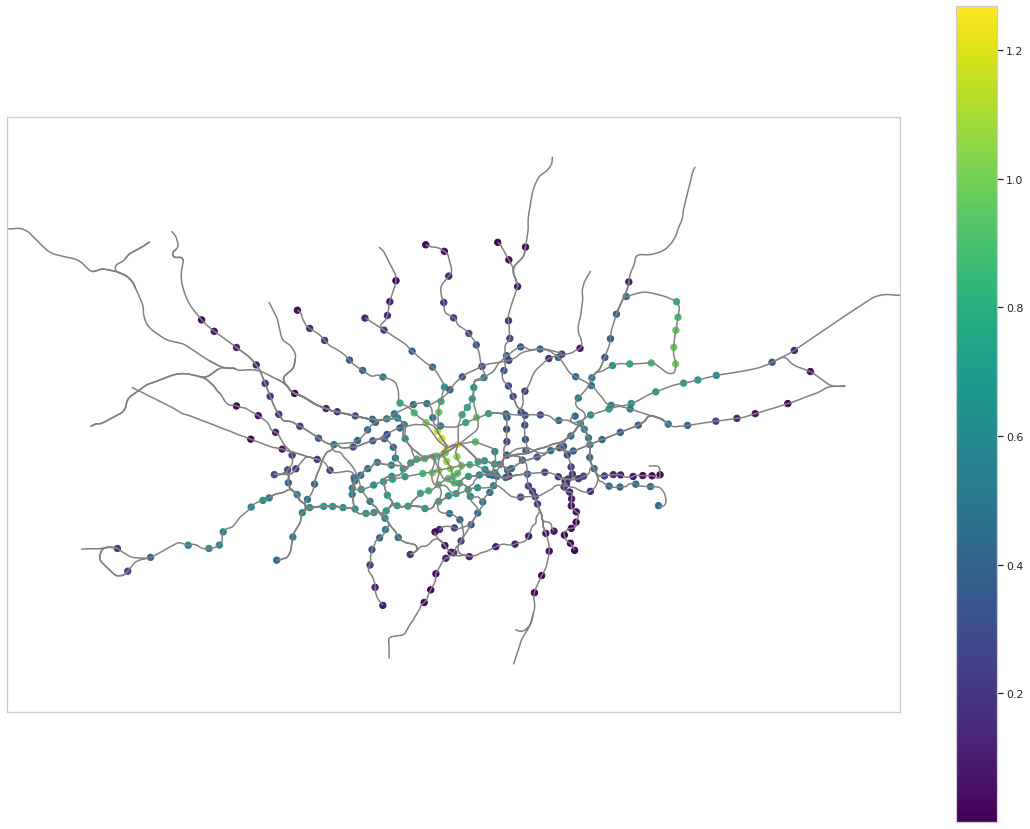

In [153]:
fig, ax = plt.subplots(figsize=(20, 15))

ax.set_xlim([500000, 560000])
ax.set_ylim([165000, 205000])
ax.set_xticks([])
ax.set_yticks([])

lines.plot(ax=ax, color='grey', edgecolor='white')
Ai_gdf.plot(column="Ai", ax=ax, marker='o', cmap='viridis', markersize=40, legend=True)
# ax.set_title("Accessibility in Normal Temperature, weighted by distance")

plt.savefig("output/model1.png")


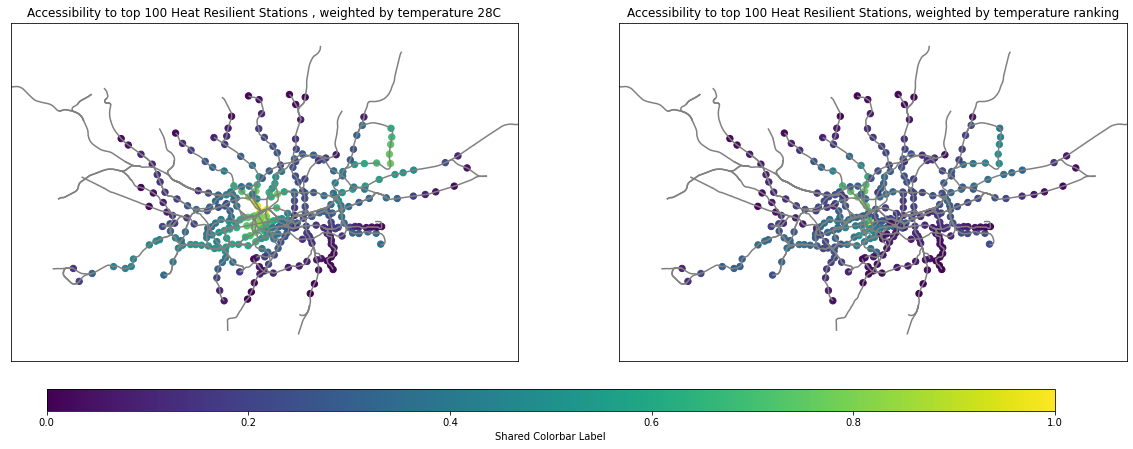

In [90]:
fig, axs = plt.subplots(1, 2, figsize=(20, 15))


# Plot for the second subplot
lines.plot(ax=axs[0], color='grey', edgecolor='white')
temp26_weight = Ai_temp26_gdf.plot(column="Ai", ax=axs[0], marker='o', cmap='viridis', markersize=40, legend=False)
axs[0].set_title("Accessibility to top 100 Heat Resilient Stations , weighted by temperature 28C")
axs[0].set_xlim([500000, 560000])
axs[0].set_ylim([165000, 205000])
axs[0].set_xticks([])
axs[0].set_yticks([])

# Plot for the third subplot
lines.plot(ax=axs[1], color='grey', edgecolor='white')
temp_ranking = Ai_rank_gdf.plot(column="Ai", ax=axs[1], marker='o', cmap='viridis', markersize=40, legend=False)
axs[1].set_title("Accessibility to top 100 Heat Resilient Stations, weighted by temperature ranking")
axs[1].set_xlim([500000, 560000])
axs[1].set_ylim([165000, 205000])
axs[1].set_xticks([])
axs[1].set_yticks([])


# Add a shared colorbar
cbar_ax = fig.add_axes([0.15, 0.3, 0.7, .02])  # Adjust the position and size of the colorbar
cbar = fig.colorbar(temp26_weight.collections[0], cax=cbar_ax, orientation='horizontal')
cbar.set_label('Shared Colorbar Label')

plt.savefig("output/model2model3.png")

# Show the plots side by side
plt.show()



### 1 Histogram of All 3 Accessibility Model

/opt/conda/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level functi

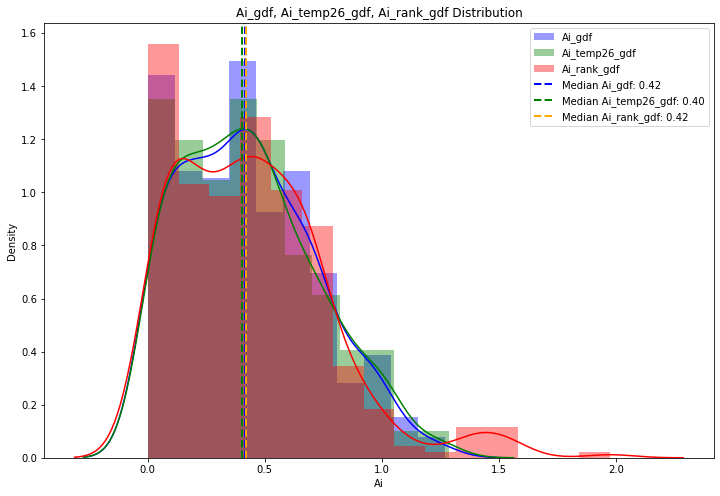

In [28]:
# Plot the distribution
fig, ax = plt.subplots(figsize=(12, 8))

sns.distplot(Ai_gdf['Ai'], label='Ai_gdf', ax=ax, color='blue')
sns.distplot(Ai_temp26_gdf['Ai'], label='Ai_temp26_gdf', ax=ax, color='green')
sns.distplot(Ai_rank_gdf['Ai'], label='Ai_rank_gdf', ax=ax, color='red')


mean_1 = Ai_gdf['Ai'].mean()
median_1 = Ai_gdf['Ai'].median()

mean_2 = Ai_temp26_gdf['Ai'].mean()
median_2 = Ai_temp26_gdf['Ai'].median()

mean_3 = Ai_rank_gdf['Ai'].mean()
median_3 = Ai_rank_gdf['Ai'].median()

# Add vertical lines for mean and median
ax.axvline(median_1, color='blue', linestyle='dashed', linewidth=2, label=f'Median Ai_gdf: {median_1:.2f}')
ax.axvline(median_2, color='green', linestyle='dashed', linewidth=2, label=f'Median Ai_temp26_gdf: {median_2:.2f}')
ax.axvline(median_3, color='orange', linestyle='dashed', linewidth=2, label=f'Median Ai_rank_gdf: {median_3:.2f}')
# ax.axvline(median_4, color='red', linestyle='dashed', linewidth=2, label=f'Median Ai_4: {median_4:.2f}')



ax.set_title('Ai_gdf, Ai_temp26_gdf, Ai_rank_gdf Distribution')
ax.legend()

plt.show()

### 2 Histograms of Differences Dataframes

/opt/conda/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


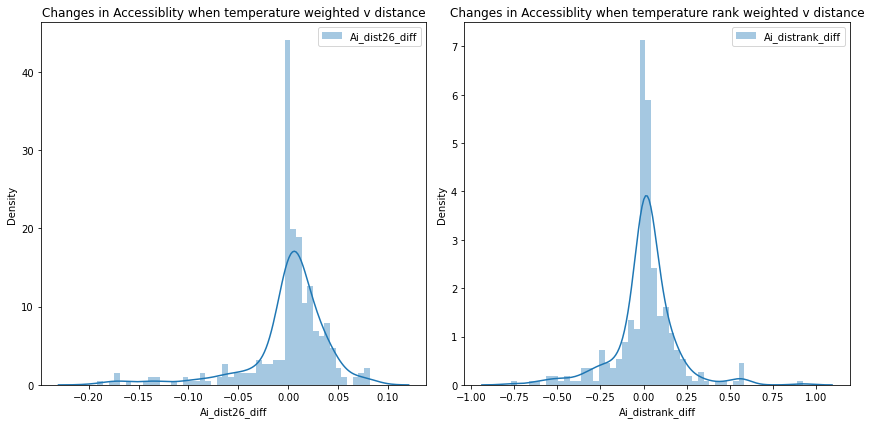

In [29]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.distplot(Ai_dist26['Ai_dist26_diff'], label='Ai_dist26_diff', ax=axes[0])
axes[0].set_title('Changes in Accessiblity when temperature weighted v distance')
axes[0].legend()

sns.distplot(Ai_distrank['Ai_distrank_diff'], label='Ai_distrank_diff', ax=axes[1])
axes[1].set_title('Changes in Accessiblity when temperature rank weighted v distance')
axes[1].legend()

plt.tight_layout()
plt.show()

### 2 Network Plots of Difference Dataframe

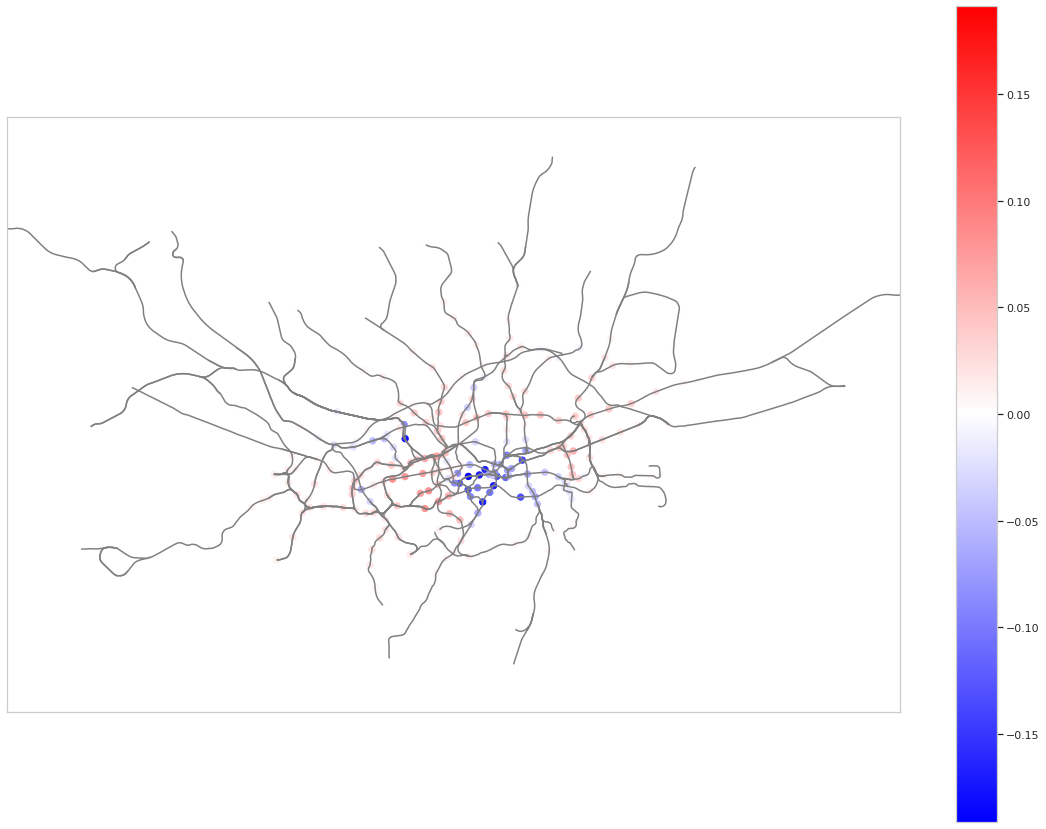

In [152]:
import matplotlib.colors as colors


fig, ax = plt.subplots(figsize=(20, 15))
cmap = plt.cm.get_cmap('bwr')

vmin = Ai_dist26['Ai_dist26_diff'].min()
vmax = - (vmin)
norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

# First subplot
lines.plot(ax=ax, color='grey', edgecolor='white', legend = True)
ax.set_xlim([500000, 560000])
ax.set_ylim([165000, 205000])
ax.set_xticks([])
ax.set_yticks([])

Ai_dist26_plot = Ai_dist26.plot(column="Ai_dist26_diff", ax=ax, marker='o', cmap=cmap, markersize=40, legend=True, vmin=vmin, vmax=vmax, norm=norm)

plt.savefig("output/model2_1_changes.png")



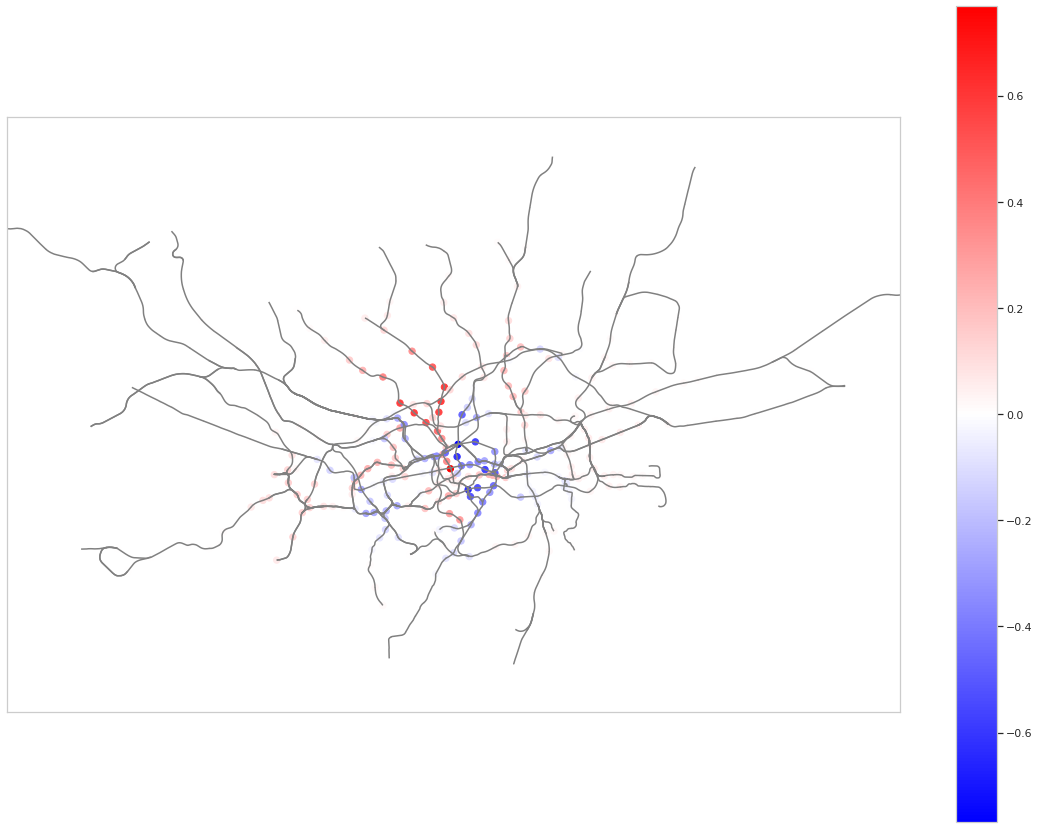

In [151]:
fig, ax = plt.subplots(figsize=(20, 15))
cmap = plt.cm.get_cmap('bwr')

vmin = Ai_distrank['Ai_distrank_diff'].min()
vmax = - (vmin)
norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

# First subplot
lines.plot(ax=ax, color='grey', edgecolor='white', legend = True)
ax.set_xlim([500000, 560000])
ax.set_ylim([165000, 205000])
ax.set_xticks([])
ax.set_yticks([])

Ai_distrank_plot = Ai_distrank.plot(column="Ai_distrank_diff", ax=ax, marker='o', cmap=cmap, markersize=40, legend=True, vmin=vmin, vmax=vmax, norm=norm)

plt.savefig("output/model3_1_changes.png")

### Cumulative Distribution Function Graph

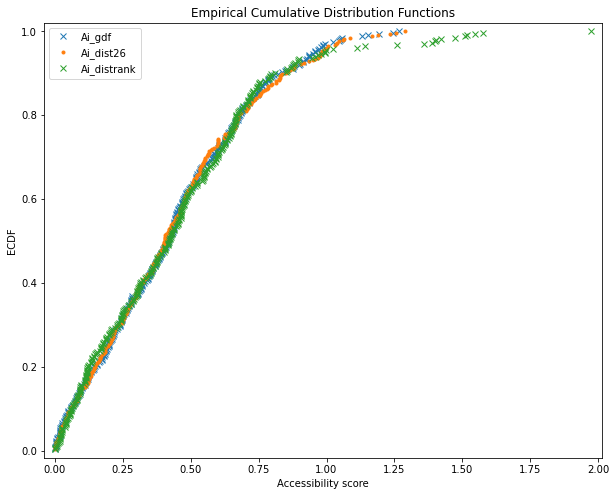

In [32]:
# Create ECDF function
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(x) + 1) / len(x)
    return x, y

# Data for the 4 ECDFs (replace with your actual data)
x_Ai_1, y_Ai_1 = ecdf(Ai_gdf['Ai'])
x_Ai_2, y_Ai_2 = ecdf(Ai_temp26['Ai'])
x_Ai_3, y_Ai_3 = ecdf(Ai_rank['Ai'])

# Create a larger plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the ECDFs
ax.plot(x_Ai_1, y_Ai_1, marker='x', linestyle='none', label='Ai_gdf')
ax.plot(x_Ai_2, y_Ai_2, marker='.', linestyle='none', label='Ai_dist26')
ax.plot(x_Ai_3, y_Ai_3, marker='x', linestyle='none', label='Ai_distrank')

# Set labels and title
ax.set_xlabel('Accessibility score')
ax.set_ylabel('ECDF')
ax.set_title('Empirical Cumulative Distribution Functions')
ax.margins(0.02)

# Add legend
ax.legend()

# Show the plot
plt.show()


20% of stations had an accessbiblity score of 0.24

You can see how model 2,3,4 all have a higher rate of change, showing that accessibility reduction in the temperature weighted models.

------

The graph is more or less the same for the 3 models, except that model 3 has a higher rate of change in the 0.5 - 1.25 accessibility score range. This is probably due to the reduction in competition, thus higher Rj score. 

underlying patterns in the data that influence accessibility scores are consistent across the models. This could indicate that the factors affecting accessibility are stable and not significantly impacted by the model variations.



In [117]:
num_catchment_dist = catchment_decay_dist_top100.groupby('stations')['buffer_name'].count().reset_index()
num_catchment_dist.sort_values('buffer_name', ascending = False)

,stations,buffer_name
247,Russell Square,62
172,Kings Cross St Pancras,62
100,Euston,61
101,Euston Square,61
272,St Pauls,61
...,...,...
139,Headstone Lane,1
44,Bush Hill Park,1
190,Loughton,1
180,Lewisham,1


In [116]:
num_catchment_temp26 = catchment_decay_temp26_top100.groupby('stations')['buffer_name'].count().reset_index()
num_catchment_temp26.sort_values('buffer_name', ascending = False)

,stations,buffer_name
172,Kings Cross St Pancras,57
246,Russell Square,57
101,Euston Square,57
179,Leicester Square,56
100,Euston,56
...,...,...
98,Emerson Park,1
95,Elm Park,1
287,Tooting Bec,1
91,Edgware,1


In [115]:
num_catchment_rank = catchment_decay_temprank_top100.groupby('stations')['buffer_name'].count().reset_index()
num_catchment_rank.sort_values('buffer_name', ascending = False)

,stations,buffer_name
184,Liverpool Street,32
284,Tottenham Court Road,31
199,Moorgate,30
3,Aldgate,29
4,Aldgate East,29
...,...,...
280,Sudbury Town,1
286,Totteridge & Whetstone,1
64,Clapham South,1
63,Clapham North,1


In [120]:
num_catchment_disttemp26

,stations,buffer_name_x,buffer_name_y
0,Abbey Road,20,17.0
1,Acton Central,13,13.0
2,Acton Town,14,14.0
3,Aldgate,50,40.0
4,Aldgate East,51,40.0
...,...,...,...
332,Wood Street,7,7.0
333,Woodford,6,6.0
334,Woodgrange Park,4,4.0
335,Woodside Park,3,3.0


In [123]:
num_catchment_disttemp26 = num_catchment_dist.merge(num_catchment_temp26, on = 'stations', how = 'left')
num_catchment_disttemp26.rename(columns = {'buffer_name_x': 'dist', 'buffer_name_y': 'temp26'}, inplace = True)
num_catchment_disttemp26rank = num_catchment_disttemp26.merge(num_catchment_rank, on = 'stations', how = 'left')
num_catchment_disttemp26rank.rename(columns = {'buffer_name': 'rank'}, inplace = True)
num_catchment_disttemp26rank['21diff'] = num_catchment_disttemp26rank['dist'] -num_catchment_disttemp26rank['temp26']
num_catchment_disttemp26rank['31diff'] = num_catchment_disttemp26rank['dist'] -num_catchment_disttemp26rank['rank']

In [129]:
num_catchment_disttemp26rank_1 = num_catchment_disttemp26rank[num_catchment_disttemp26rank['31diff'] > 0]
num_catchment_disttemp26rank_1 = num_catchment_disttemp26rank_1.sort_values('31diff', ascending = False)
num_catchment_disttemp26rank_1

,stations,dist,temp26,rank,21diff,31diff
272,St Pauls,61,46.0,7.0,15.0,54.0
13,Bank,60,49.0,9.0,11.0,51.0
310,Waterloo,55,44.0,5.0,11.0,50.0
100,Euston,61,56.0,13.0,5.0,48.0
175,Lambeth North,52,41.0,4.0,11.0,48.0
...,...,...,...,...,...,...
123,Greenwich,3,3.0,2.0,0.0,1.0
1,Acton Central,13,13.0,12.0,0.0,1.0
135,Harringay Green Lanes,7,7.0,6.0,0.0,1.0
157,Ilford,12,12.0,11.0,0.0,1.0


In [135]:
num_catchment_disttemp26rank_1.reset_index(inplace=True)

In [149]:
num_catchment_disttemp26rank_1 = num_catchment_disttemp26rank_1.sort_values('rank', ascending = False)

In [150]:
num_catchment_disttemp26rank_1

,index,stations,dist,temp26,rank,21diff,31diff
74,186,Liverpool Street,59,49.0,32.0,10.0,27.0
70,289,Tottenham Court Road,60,53.0,31.0,7.0,29.0
65,201,Moorgate,59,49.0,30.0,10.0,29.0
145,191,Maida Vale,43,40.0,29.0,3.0,14.0
107,4,Aldgate East,51,40.0,29.0,11.0,22.0
...,...,...,...,...,...,...,...
233,284,Sudbury Town,2,2.0,1.0,0.0,1.0
191,133,Hanger Lane,5,5.0,1.0,0.0,4.0
119,61,Clapham Common,21,19.0,1.0,2.0,20.0
96,64,Clapham North,25,24.0,1.0,1.0,24.0


In [141]:
final_numcatch =num_catchment_disttemp26rank_1.drop(['index','21diff', '31diff'], axis = 1)

In [165]:
final_numcatch30 = final_numcatch.head(30)
final_numcatch30tail = final_numcatch.tail(30)

In [166]:
melted_df = final_numcatch30.melt(id_vars='stations', var_name='measurement', value_name='value')
meltedtail_df = final_numcatch30tail.melt(id_vars='stations', var_name='measurement', value_name='value')


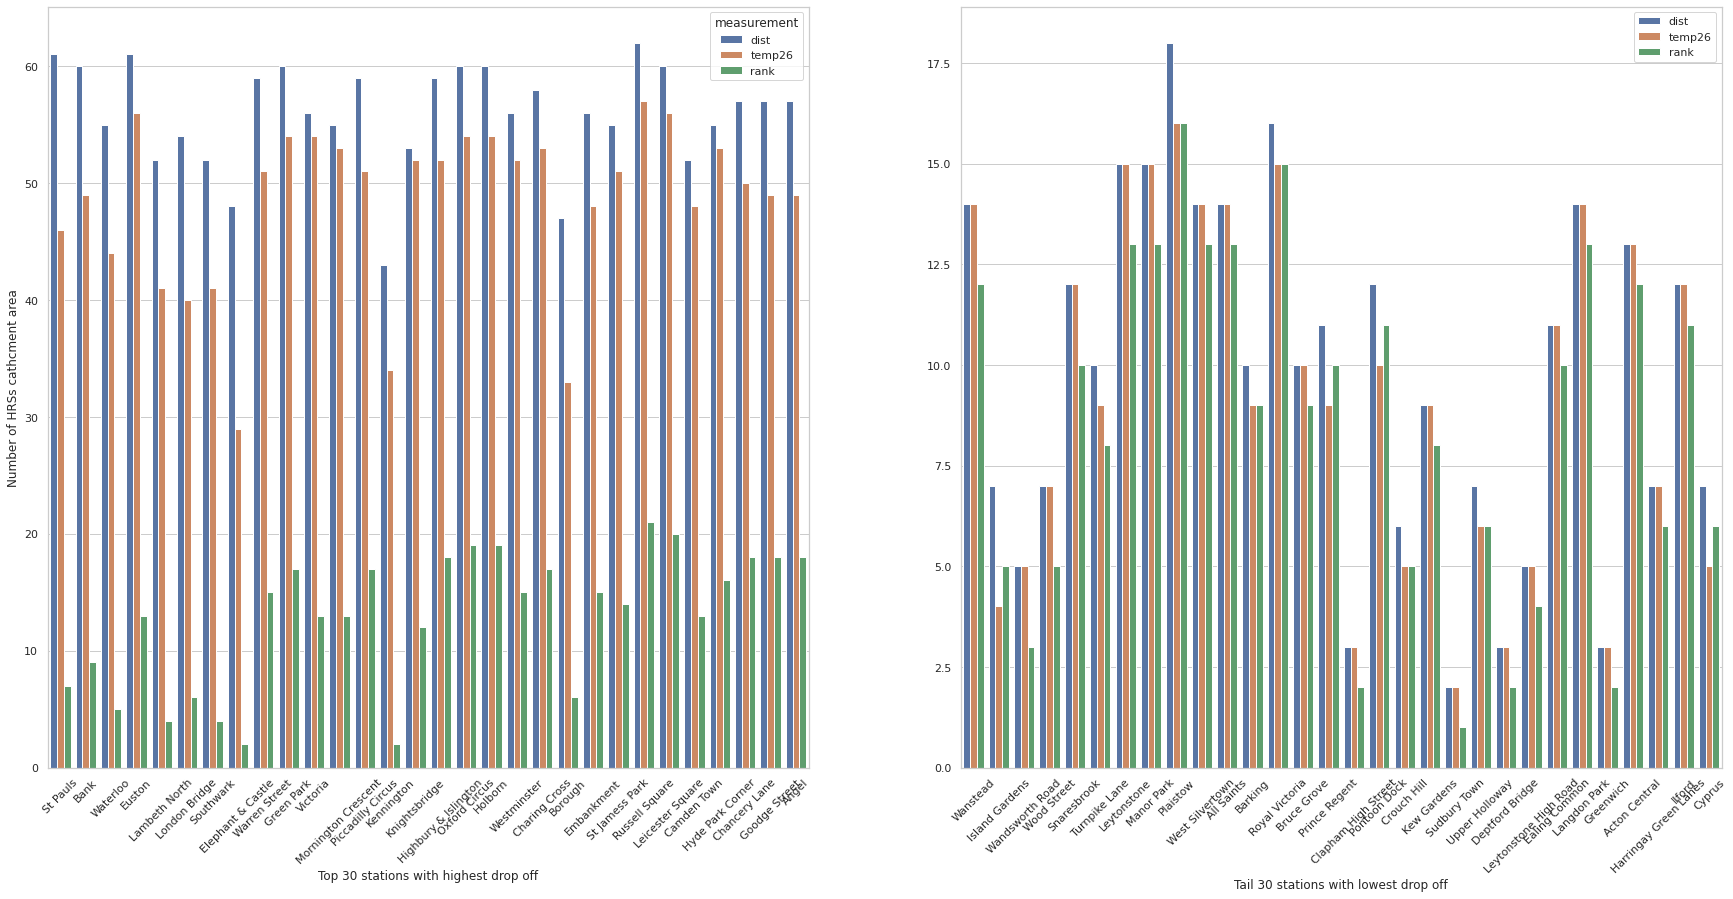

In [176]:
fig, axs = plt.subplots(1, 2, figsize=(30, 14))

g = sns.barplot(
    data=melted_df, x='stations', y='value', hue='measurement', ax=axs[0])

# Tilt the x-axis labels for better readability
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)  # Adjust the rotation angle as needed
axs[0].set_ylabel("Number of HRSs cathcment area")
axs[0].set_xlabel("Top 30 stations with highest drop off")

# axs[0].legend(loc='upper right', bbox_to_anchor=(1, 1))

g2 = sns.barplot(
    data=meltedtail_df, x='stations', y='value', hue='measurement', ax=axs[1])

# Tilt the x-axis labels for better readability
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45)  # Adjust the rotation angle as needed
axs[1].set_ylabel("")
axs[1].set_xlabel("Tail 30 stations with lowest drop off")

axs[1].legend(loc='upper right', bbox_to_anchor=(1, 1))

plt.savefig("output/catchment_drop_off.png")


plt.show()